In [1]:
!pip install -qU pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 3.4 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from kan import *

In [4]:
# Load Data
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
submit = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [5]:
# Data Preprocessing
def preprocess(df):
    df = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
    df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
    df['Embarked'].fillna('S', inplace=True)
    df['Embarked'] = LabelEncoder().fit_transform(df['Embarked'])
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    return df

train_data = preprocess(train)
test_data = preprocess(test)
y = train['Survived'].values
X_train, X_val, y_train, y_val = train_test_split(train_data, y, test_size=0.2, random_state=42)

In [6]:
# Normalize
def normalize(X_train, X_val, test_data):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    test_data = scaler.transform(test_data)
    return X_train, X_val, test_data

X_train, X_val, test_data = normalize(X_train, X_val, test_data)

In [7]:
# Initialize KAN
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = KAN(width=[X_train.shape[1], 10, 5, 1], grid=3, k=3, seed=42, device=device)

checkpoint directory created: ./model
saving model version 0.0


In [8]:
# Training the Model
model.fit({'train_input': torch.tensor(X_train, dtype=torch.float64, device=device),
           'train_label': torch.tensor(y_train, dtype=torch.float64, device=device).view(-1, 1),
           'test_input': torch.tensor(X_val, dtype=torch.float64, device=device),
           'test_label': torch.tensor(y_val, dtype=torch.float64, device=device).view(-1, 1)},
          opt="LBFGS", steps=100, lamb=0.001)

| train_loss: 2.69e-01 | test_loss: 4.62e-01 | reg: 1.76e+01 | : 100%|█| 100/100 [01:06<00:00,  1.49

saving model version 0.1


{'train_loss': [array(0.36654475),
  array(0.34554489),
  array(0.34092191),
  array(0.33484295),
  array(0.33048714),
  array(0.33051175),
  array(0.32654944),
  array(0.32166768),
  array(0.31876927),
  array(0.31666376),
  array(0.32172062),
  array(0.31783793),
  array(0.31380476),
  array(0.30935385),
  array(0.30582717),
  array(0.30845997),
  array(0.30518208),
  array(0.30222272),
  array(0.29941233),
  array(0.2976827),
  array(0.30312512),
  array(0.29987195),
  array(0.29718957),
  array(0.29473579),
  array(0.29283834),
  array(0.2946991),
  array(0.29304019),
  array(0.29172151),
  array(0.29064279),
  array(0.28960652),
  array(0.29165197),
  array(0.28958559),
  array(0.28840803),
  array(0.28768615),
  array(0.28671279),
  array(0.28875744),
  array(0.28649695),
  array(0.28574458),
  array(0.28497605),
  array(0.28442899),
  array(0.2872793),
  array(0.28527518),
  array(0.28411542),
  array(0.28361008),
  array(0.28322373),
  array(0.28488311),
  array(0.28386739),
  

In [9]:
# Extract Symbolic Formula
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with x^2, r2=0.9999999624050644, c=2
fixing (0,0,1) with x^2, r2=0.9999999134546288, c=2
fixing (0,0,2) with x^2, r2=0.9999999900344441, c=2
fixing (0,0,3) with x^2, r2=0.9999997760795909, c=2
fixing (0,0,4) with x^2, r2=0.9999999990073805, c=2
fixing (0,0,5) with x^2, r2=0.99999999772926, c=2
fixing (0,0,6) with x^2, r2=0.9999999927730091, c=2
fixing (0,0,7) with x^2, r2=0.9999999999816064, c=2
fixing (0,0,8) with x^2, r2=0.9999999999937494, c=2
fixing (0,0,9) with exp, r2=0.9999999999996605, c=2
fixing (0,1,0) with x, r2=0.999999534580829, c=1
fixing (0,1,1) with x, r2=0.9999424721057477, c=1
fixing (0,1,2) with x, r2=0.999997876639326, c=1
fixing (0,1,3) with x, r2=0.9999903085153847, c=1
fixing (0,1,4) with x, r2=0.999998607302843, c=1
fixing (0,1,5) with x, r2=0.9999999957805508, c=1
fixing (0,1,6) with x, r2=0.9999991041610372, c=1
fixing (0,1,7) with x, r2=0.9999999983573044, c=1
fixing (0,1,8) with x, r2=0.9999999793031519, c=1
fixing (0,1,9) with x, r2=0.9999999

In [10]:
# Output Final Symbolic Formula
from kan.utils import ex_round
final_formula = ex_round(model.symbolic_formula()[0][0], 4)
print("Final Model Formula:", final_formula)

Final Model Formula: -0.0304*x_2 - 0.0739*x_3 + 0.0036*x_5 + 0.0157*x_6 + 0.007*(0.4863 - x_1)**2 + 0.0119*(1 - 0.3236*x_1)**2 - 0.001*(1 - 0.8818*x_4)**2 - 0.e-4*(1 - 0.7445*x_4)**2 - 0.0006*(1 - 0.6484*x_4)**2 - 0.0041*(1 - 0.6*x_4)**2 - 0.0094*(1 - 0.4629*x_4)**2 + 0.0016*(1 - 0.4163*x_5)**2 + 0.0291*(1 - 0.3073*x_5)**2 - 0.0015*(-x_1 - 0.8269)**2 + 0.0398*(-x_1 - 0.8036)**2 + 0.0112*(-x_1 - 0.4769)**2 + 0.0042*(-x_1 - 0.1884)**2 - 0.0013*(-x_1 - 0.0341)**2 - 0.1251*(-0.4087*x_1 - 1)**2 - 0.0341*(-0.0761*x_1 - 1)**2 + 0.0052*(-0.7631*x_3 - 1)**2 - 0.0086*(-x_7 - 0.8502)**2 + 0.0002*(-x_7 - 0.7302)**2 + 0.0015*(-x_7 - 0.5803)**2 + 0.0016*(-x_7 - 0.5716)**2 - 0.0305*(-x_7 - 0.5203)**2 + 0.0074*(-x_7 - 0.3682)**2 + 0.0194*(-0.8003*x_7 - 1)**2 - 0.0083*(-0.503*x_7 - 1)**2 + 0.0406*(-0.4772*x_7 - 1)**2 - 0.0597*(-0.4662*x_7 - 1)**2 + 0.0436*log(5.4134*x_6 + 6.0215) + 0.0011*log(-0.0006*x_2 - 0.001*x_3 - 0.e-4*(1 - 0.6*x_4)**2 - 0.0004*(1 - 0.4629*x_4)**2 + 0.0001*(1 - 0.4163*x_5)**2 + 0.

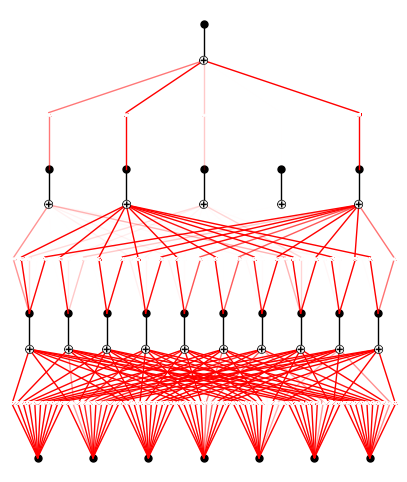

In [11]:
# Visualize KAN
model.plot(beta=100)

In [12]:
# Predictions
test_preds = model(torch.tensor(test_data, dtype=torch.float64, device=device)).cpu().detach().numpy()
test_preds = (test_preds > 0.5).astype(int)

In [13]:
# Submission
submission = pd.DataFrame({'PassengerId': submit['PassengerId'], 'Survived': test_preds.ravel()})
submission.to_csv('kan_submission.csv', index=False)